In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"debashish0sarker","key":"889ec46e790212e1771d258ca88d6db4"}'}

In [3]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d debashish0sarker/captcha-shortened

Dataset URL: https://www.kaggle.com/datasets/debashish0sarker/captcha-shortened
License(s): unknown
100% 3.35G/3.35G [00:32<00:00, 181MB/s]
100% 3.35G/3.35G [00:32<00:00, 109MB/s]


In [5]:
!unzip captcha-shortened.zip -d captcha_shortened

Streaming output truncated to the last 5000 lines.
  inflating: captcha_shortened/SPHINX_shortened/ZOUA_378480.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUB_423764.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUC_118519.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUC_601525.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUF_386752.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUG_855976.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUI_232716.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUI_709128.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUJ_524944.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUJ_814891.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUO_195100.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUO_317513.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUP_563916.png  
  inflating: captcha_shortened/SPHINX_shortened/ZOUQ_404157.png  
  inflating: captcha_shor

In [6]:
!pip install -q torchsummary

In [ ]:
!pip install --upgrade torch-summary

^C


In [ ]:
import torch
print(torch.__version__)

2.8.0+cu126


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
import os

# List files in the /kaggle/input/ directory
for filename in os.listdir('/kaggle/input'):
    print(filename)


captcha


In [8]:
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm

In [10]:
DATA_DIR_SPHINX = '/kaggle/input/captcha/SPHINX/SPHINX/'
DATA_DIR_SPHINX_RESIZED = '/kaggle/input/captcha/SPHINX_resized/SPHINX_resized/'
#Model Hyperparamters
BATCH_SIZE=64
VAL_SPLIT=0.20
#CRNN
CRNN_KERNEL=5
CRNN_POOL_KERNEL=2
CRNN_DROPOUT=0.3
CRNN_LATENT=128
LSTM_HIDDEN_DIM=32
VOCAB_SIZE=26
OUTPUT_LENGTH=4
#AFFN
AFFN_KERNEL=5
AFFN_STRIDE=1
AFFN_DEPTH=4

#CRNN
CRNN_KERNEL=5
CRNN_POOL_KERNEL=2
CRNN_DROPOUT=0.3
CRNN_LATENT=64
LSTM_HIDDEN_DIM=32
VOCAB_SIZE=26
OUTPUT_LENGTH=4


SAVE_EPOCH=10
VAL_EPOCH=1
EPOCHS=10

In [11]:
# Correct parent directory for dataset
DATA_DIR = "/content/captcha_shortened/SPHINX_shortened"



In [ ]:
DATA_DIR_SPHINX = os.path.join(DATA_DIR, 'SPHINX', 'SPHINX')  # Full path to SPHINX
DATA_DIR_SPHINX_RESIZED = os.path.join(DATA_DIR, 'SPHINX_resized', 'SPHINX_resized')  # Full path to SPHINX_resized
print(DATA_DIR_SPHINX)
print(DATA_DIR_SPHINX_RESIZED)

/kaggle/input/captcha/SPHINX/SPHINX
/kaggle/input/captcha/SPHINX_resized/SPHINX_resized


In [12]:
import os
import torch
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from PIL import Image
import string

DATA_DIR = "/content/captcha_shortened/SPHINX_shortened"

def get_dataloaders(data_dir, batch_size, val_split, shuffle=True, num_workers=2):
    characters = string.ascii_uppercase  # A–Z
    char_to_idx = {char: idx for idx, char in enumerate(characters)}

    class CustomDataset(Dataset):
        def __init__(self, root_dir, transform=None):
            self.image_paths, self.labels = [], []
            self.transform = transform

            for f in os.listdir(root_dir):
                if f.lower().endswith(('png', 'jpg', 'jpeg')):
                    label = f.split('_')[0][:4]  # first 4 chars before "_"
                    if len(label) == 4 and label != "AAAA":  # enforce valid 4-char label
                        self.image_paths.append(os.path.join(root_dir, f))
                        self.labels.append(label)

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            image = Image.open(self.image_paths[idx]).convert('RGB')
            label_str = self.labels[idx]
            label_indices = [char_to_idx[c] for c in label_str]

            label_tensor = torch.tensor(label_indices, dtype=torch.long)  # indices instead of fake one-hot
            if self.transform:
                image = self.transform(image)

            return image, label_tensor

    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),   # make single channel
        transforms.Resize((40, 150)),                  # resize for consistency
        transforms.ToTensor(),                         # normalize to [0,1]
    ])

    dataset = CustomDataset(data_dir, transform)

    # train/val split
    total_size = len(dataset)
    val_size = int(total_size * val_split)
    train_size = total_size - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, char_to_idx


In [22]:
train_loader, val_loader, char_to_idx = get_dataloaders(DATA_DIR, batch_size=64, val_split=0.2)

In [13]:
print(DATA_DIR)

/content/captcha_shortened/SPHINX_shortened


In [ ]:
for X,y in train_loader:
    print(X.shape)
    print(y.shape)
    break

torch.Size([64, 1, 40, 150])
torch.Size([64, 4])


In [14]:
class Encoder(nn.Sequential):
    def __init__(self,n,kernel_size,stride):
        super().__init__(
            nn.Conv2d(in_channels=4**(n-1),out_channels=4**n,kernel_size=kernel_size,stride=stride),
            nn.BatchNorm2d(num_features=4**n),
            nn.ReLU(inplace=False)
        )

In [15]:
class Decoder(nn.Sequential):
    def __init__(self,n,kernel_size,stride):
        super().__init__(
            nn.ConvTranspose2d(in_channels=4**n,out_channels=4**(n-1),kernel_size=kernel_size,stride=stride),
            nn.BatchNorm2d(num_features=4**(n-1)),
            nn.ReLU(inplace=False)
        )

In [16]:
class CRNN(nn.Module):
    def __init__(self, in_channels, kernel_size, pool_kernel_size, dropout, latent_dim, lstm_hidden_dim, vocab_size, output_length=4):
        super().__init__()
        self.lstm_hidden_dim = lstm_hidden_dim
        self.output_length = output_length  # Should be 4 for 4 characters
        self.vocab_size = vocab_size

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels*2, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_features=in_channels*2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=pool_kernel_size)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels*2, out_channels=in_channels*4, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_features=in_channels*4),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=pool_kernel_size)
        )
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout)
        self.latent_fc = nn.LazyLinear(latent_dim)
        self.lstm = nn.LSTM(input_size=latent_dim, hidden_size=lstm_hidden_dim, num_layers=1, batch_first=True)
        self.output_fc = nn.Linear(lstm_hidden_dim, vocab_size)

    def forward(self, x):
        batch_size = x.size(0)

        # CNN feature extraction
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(conv1_out)
        flattened = self.flatten(conv2_out)
        dropped = self.dropout(flattened)
        latent = self.latent_fc(dropped)

        lstm_input = latent.unsqueeze(1)

        # Initialize hidden and cell states
        h0 = torch.zeros(1, batch_size, self.lstm_hidden_dim, device=x.device)
        c0 = torch.zeros(1, batch_size, self.lstm_hidden_dim, device=x.device)

        outputs = []

        # Generate 5 characters sequentially
        for _ in range(self.output_length):
            out, (h0, c0) = self.lstm(lstm_input, (h0, c0))  # out shape: (batch_size, 1, lstm_hidden_dim)

            logits = self.output_fc(out.squeeze(1))  # Shape: (batch_size, vocab_size)

            outputs.append(logits)

        outputs = torch.stack(outputs, dim=1)  # Shape: (batch_size, 4, vocab_size)

        return outputs

In [17]:
class AFFN(nn.Module):
    def __init__(self,n):
        super().__init__()
        self.n=n
        # self.test=nn.Linear(1,2)
        self.alpha=nn.Parameter(torch.randn(n-1).to(device)).to(device)
        self.encoders=[]
        for i in range(1,n+1):
            self.encoders.append(Encoder(i,AFFN_KERNEL,AFFN_STRIDE).to(device))

        self.decoders=[]
        for i in range(n,0,-1):
            self.decoders.append(Decoder(i,AFFN_KERNEL,AFFN_STRIDE).to(device))

    def forward(self, x):
        residuals = []
        for i, enc in enumerate(self.encoders):
            x = enc(x)
            if i < self.n - 1:
                x = x * (1 - self.alpha[i])
                residuals.append(x * self.alpha[i])

        for i, dec in enumerate(self.decoders):
            x = dec(x)
            if i < self.n - 1:
                x = x + residuals.pop()

        return x

In [18]:
class CaptchaCrackNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.affn=AFFN(AFFN_DEPTH).to(device)

        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=5,padding=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2=nn.Sequential(
                    nn.Conv2d(in_channels=32,out_channels=48,kernel_size=5,padding=2),
                    nn.ReLU(inplace=False),
                    nn.MaxPool2d(kernel_size=2)
                )

        self.conv3=nn.Sequential(
            nn.Conv2d(in_channels=48,out_channels=64,kernel_size=5,padding=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2)
        )

        self.res=nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=2, padding=2)

        self.crnn=CRNN(64,CRNN_KERNEL,CRNN_POOL_KERNEL,CRNN_DROPOUT,CRNN_LATENT,LSTM_HIDDEN_DIM,VOCAB_SIZE,OUTPUT_LENGTH).to(device)

    def forward(self,x):
        affn_out=self.affn(x)
        res_out=self.res(x)
        conv1_out=self.conv1(affn_out)
        conv2_out=self.conv2(conv1_out+res_out)
        conv3_out=self.conv3(conv2_out)
        output=self.crnn(conv3_out)
        return output


In [ ]:
class CRNN_AFFN(nn.Module):
    def __init__(self, affn, crnn):
        super().__init__()
        self.affn = affn
        self.crnn = crnn

    def forward(self, x):
        x = self.affn(x)   # denoise/feature enhance
        x = self.crnn(x)   # sequence prediction
        return x


In [ ]:
# Check if validation data has the right format
print("Checking validation data...")
for X, y in val_loader:
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    print(f"Sample y values: {y[0]}")
    print(f"Max y value: {y.max()}, Min y value: {y.min()}")  # Should be between 0-25
    break

Checking validation data...
X shape: torch.Size([64, 1, 40, 150]), y shape: torch.Size([64, 4])
Sample y values: tensor([ 6, 16, 16, 16])
Max y value: 25, Min y value: 0


In [ ]:
affn = AFFN(n=3).to(device)
crnn = CRNN(in_channels=1, kernel_size=3, pool_kernel_size=2,
            dropout=0.5, latent_dim=128, lstm_hidden_dim=256,
            vocab_size=26, output_length=4).to(device)

model = CRNN_AFFN(affn, crnn)


In [ ]:
def accuracy_fn(preds, targets):
    """
    preds shape: (batch_size, 4, 26) - 4 characters, 26 classes each
    targets shape: (batch_size, 4) - 4 character indices
    """
    # Get predicted class for each character position (4 characters)
    preds_class = torch.argmax(preds, dim=2)  # Shape: (batch_size, 4)

    # Compare predicted vs actual characters
    correct = (preds_class == targets).sum().item()  # Total correct characters
    total = targets.numel()  # Total characters (64 * 4 = 256)

    accuracy = correct / total * 100
    return accuracy
def loss_fn(preds,target):
    ce_loss=F.cross_entropy(preds,target)
    # ctc_loss=F.ctc_loss(preds,target,torch.tensor(OUTPUT_LENGTH),torch.tensor(OUTPUT_LENGTH))

    # total_loss=ce_loss#+ctc_loss
    return ce_loss


def train(model,train_loader,val_loader,optimizer,loss_fn,epochs):
    train_history=[]
    val_history=[]
    model.to(device)
    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}:")
        model.train()
        avg_loss=0
        total_train_accuracy = 0
        for batch_num,(X,y) in enumerate(tqdm(train_loader,desc="Progress: ")):
            X=X.to(device)
            y=y.to(device)
            optimizer.zero_grad()
            preds=model(X)

            loss=loss_fn(preds.view(-1, VOCAB_SIZE),y.view(-1))
            loss.backward()
            optimizer.step()
            train_accuracy = accuracy_fn(preds, y)
            total_train_accuracy += train_accuracy

            avg_loss+=loss.item()
        avg_loss/=len(train_loader)
        avg_train_accuracy = total_train_accuracy / len(train_loader)
        train_history.append(avg_loss)

        print(f"Loss: {avg_loss}")
        print(f"Train Loss: {avg_loss:.4f}, Train Accuracy: {avg_train_accuracy:.2f}%")


        eval_loss=0
        total_val_accuracy = 0
        if VAL_EPOCH and epoch%VAL_EPOCH==0:
            model.eval()
            with torch.no_grad():
                for batch_num,(X,y) in enumerate(tqdm(val_loader,desc="Progress: ")):
                    X=X.to(device)
                    y=y.to(device)
                    preds=model(X)
                    loss=loss_fn(preds.view(-1, VOCAB_SIZE),y.view(-1))

                    eval_loss+=loss.item()
                    val_accuracy = accuracy_fn(preds, y)
                    total_val_accuracy += val_accuracy


                eval_loss/=len(val_loader)
                val_history.append(eval_loss)
                #total_val_accuracy += val_accuracy
                avg_val_accuracy = total_val_accuracy / len(val_loader)
                print(f"Val Loss: {eval_loss}",eval_loss)

                print(f"Validation Loss: {eval_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.2f}%")

        if SAVE_EPOCH and epoch%SAVE_EPOCH==0:
            print("Saving model")
            path=str(epoch)+'.pth'
            torch.save(model.state_dict(), path)
    torch.save(model.state_dict(),'final.pth')
    return train_history,val_history

In [34]:
#####saved one

def accuracy_fn(preds, targets):
    """
    preds: (batch, 4, 26)  - 4 characters, 26 classes each
    targets: (batch, 4)    - 4 character indices
    """
    preds_class = torch.argmax(preds, dim=2)  # (batch, 4)

    # Character-level accuracy
    char_correct = (preds_class == targets).sum().item()
    char_total = targets.numel()
    char_acc = char_correct / char_total * 100

    # Sequence-level accuracy (all 4 chars correct)
    seq_correct = (preds_class == targets).all(dim=1).sum().item()
    seq_total = targets.size(0)
    seq_acc = seq_correct / seq_total * 100

    return char_acc, seq_acc

def loss_fn(preds,target):
    ce_loss=F.cross_entropy(preds,target)
    # ctc_loss=F.ctc_loss(preds,target,torch.tensor(OUTPUT_LENGTH),torch.tensor(OUTPUT_LENGTH))

    # total_loss=ce_loss#+ctc_loss
    return ce_loss


def train(model, train_loader, val_loader, optimizer, loss_fn, epochs, start_epoch=1):
    train_history = []
    val_history = []
    model.to(device)

    os.makedirs('checkpoints', exist_ok=True)

    for epoch in range(start_epoch, epochs + 1):  # ✅ resume from start_epoch
        print(f"\n📌 Epoch {epoch}:")
        model.train()
        avg_loss = 0

        # raw counters
        train_char_correct, train_char_total = 0, 0
        train_seq_correct, train_seq_total = 0, 0

        try:
            for X, y in tqdm(train_loader, desc="Training: "):
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()

                preds = model(X)
                loss = loss_fn(preds.view(-1, VOCAB_SIZE), y.view(-1))
                loss.backward()
                optimizer.step()

                # accuracy tracking
                char_acc, seq_acc = accuracy_fn(preds, y)
                train_char_correct += (torch.argmax(preds, dim=2) == y).sum().item()
                train_char_total += y.numel()
                train_seq_correct += (torch.argmax(preds, dim=2) == y).all(dim=1).sum().item()
                train_seq_total += y.size(0)

                avg_loss += loss.item()

        except Exception as e:
            print(f"⚠️ Training interrupted: {e}")
            torch.save(model.state_dict(), 'checkpoints/interrupted_epoch.pth')
            break

        avg_loss /= len(train_loader)
        avg_train_char_acc = train_char_correct / train_char_total * 100
        avg_train_seq_acc = train_seq_correct / train_seq_total * 100
        train_history.append(avg_loss)

        print(f"Train Loss: {avg_loss:.4f}, Char Acc: {avg_train_char_acc:.2f}%, Seq Acc: {avg_train_seq_acc:.2f}%")

        # 🔎 Validation
        eval_loss, val_char_correct, val_char_total = 0, 0, 0
        val_seq_correct, val_seq_total = 0, 0

        if VAL_EPOCH and epoch % VAL_EPOCH == 0:
            model.eval()
            with torch.no_grad():
                for X, y in tqdm(val_loader, desc="Validation: "):
                    X, y = X.to(device), y.to(device)
                    preds = model(X)
                    loss = loss_fn(preds.view(-1, VOCAB_SIZE), y.view(-1))

                    eval_loss += loss.item()
                    val_char_correct += (torch.argmax(preds, dim=2) == y).sum().item()
                    val_char_total += y.numel()
                    val_seq_correct += (torch.argmax(preds, dim=2) == y).all(dim=1).sum().item()
                    val_seq_total += y.size(0)

            eval_loss /= len(val_loader)
            val_history.append(eval_loss)
            avg_val_char_acc = val_char_correct / val_char_total * 100
            avg_val_seq_acc = val_seq_correct / val_seq_total * 100

            print(f"Validation Loss: {eval_loss:.4f}, Char Acc: {avg_val_char_acc:.2f}%, Seq Acc: {avg_val_seq_acc:.2f}%")

        # Save checkpoint
        epoch_path = f'checkpoints/epoch_{epoch}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_loss,
            'train_char_acc': avg_train_char_acc,
            'train_seq_acc': avg_train_seq_acc,
            'val_loss': eval_loss if VAL_EPOCH and epoch % VAL_EPOCH == 0 else None,
            'val_char_acc': avg_val_char_acc if VAL_EPOCH and epoch % VAL_EPOCH == 0 else None,
            'val_seq_acc': avg_val_seq_acc if VAL_EPOCH and epoch % VAL_EPOCH == 0 else None
        }, epoch_path)

        print(f"✅ Model saved: {epoch_path}")
        torch.save(model.state_dict(), 'checkpoints/latest.pth')

    torch.save(model.state_dict(), 'checkpoints/final.pth')
    return train_history, val_history


In [ ]:
# Test model output
model.eval()
with torch.no_grad():
    X, y = next(iter(val_loader))
    X = X.to(device)
    preds = model(X)
    print(f"Model output shape: {preds.shape}")  # Should be (64, 4, 26)

Model output shape: torch.Size([64, 4, 26])


In [27]:
train_history, val_history = train(
    model, train_loader, val_loader,
    optimizer, nn.CrossEntropyLoss(),
    epochs=EPOCHS,
    start_epoch=start_epoch
)


TypeError: train() got an unexpected keyword argument 'epochs'

In [29]:
resume_checkpoint = "checkpoints/epoch_7.pth"   # change to your last checkpoint

model = CaptchaCrackNet().to(device)
optimizer = torch.optim.Adam(model.parameters())

start_epoch = 1
if os.path.exists(resume_checkpoint):
    print(f"🔄 Resuming from {resume_checkpoint}")
    checkpoint = torch.load(resume_checkpoint, map_location=device)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    start_epoch = checkpoint['epoch'] + 1
else:
    print("⚠️ No checkpoint found, training from scratch.")

# 🚀 Continue training from where it left off
train_history, val_history = train(
    model, train_loader, val_loader,
    optimizer, loss_fn,
    epochs=EPOCHS,          # total epochs you want
    start_epoch=start_epoch # resume point
)


🔄 Resuming from checkpoints/epoch_7.pth

📌 Epoch 8:


Training: 100%|██████████| 4627/4627 [28:31<00:00,  2.70it/s]


Train Loss: 0.0413, Char Acc: 98.74%, Seq Acc: 95.13%


Validation: 100%|██████████| 1157/1157 [01:23<00:00, 13.89it/s]


Validation Loss: 0.0293, Char Acc: 99.03%, Seq Acc: 96.22%
✅ Model saved: checkpoints/epoch_8.pth

📌 Epoch 9:


Training: 100%|██████████| 4627/4627 [28:29<00:00,  2.71it/s]


Train Loss: 0.0270, Char Acc: 99.13%, Seq Acc: 96.60%


Validation: 100%|██████████| 1157/1157 [01:23<00:00, 13.90it/s]


Validation Loss: 0.0203, Char Acc: 99.32%, Seq Acc: 97.37%
✅ Model saved: checkpoints/epoch_9.pth

📌 Epoch 10:


Training: 100%|██████████| 4627/4627 [28:29<00:00,  2.71it/s]


Train Loss: 0.0232, Char Acc: 99.24%, Seq Acc: 97.01%


Validation: 100%|██████████| 1157/1157 [01:23<00:00, 13.93it/s]


Validation Loss: 0.0190, Char Acc: 99.37%, Seq Acc: 97.52%
✅ Model saved: checkpoints/epoch_10.pth


In [32]:
def train(model, train_loader, val_loader, optimizer, loss_fn, epochs, start_epoch=1):
    train_losses, val_losses = [], []

    for epoch in range(start_epoch, epochs+1):
        model.train()
        running_loss = 0.0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                output = model(X)
                loss = loss_fn(output, y)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")

        # save checkpoint
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict()
        }, f"checkpoints/epoch_{epoch}.pth")

    return train_losses, val_losses


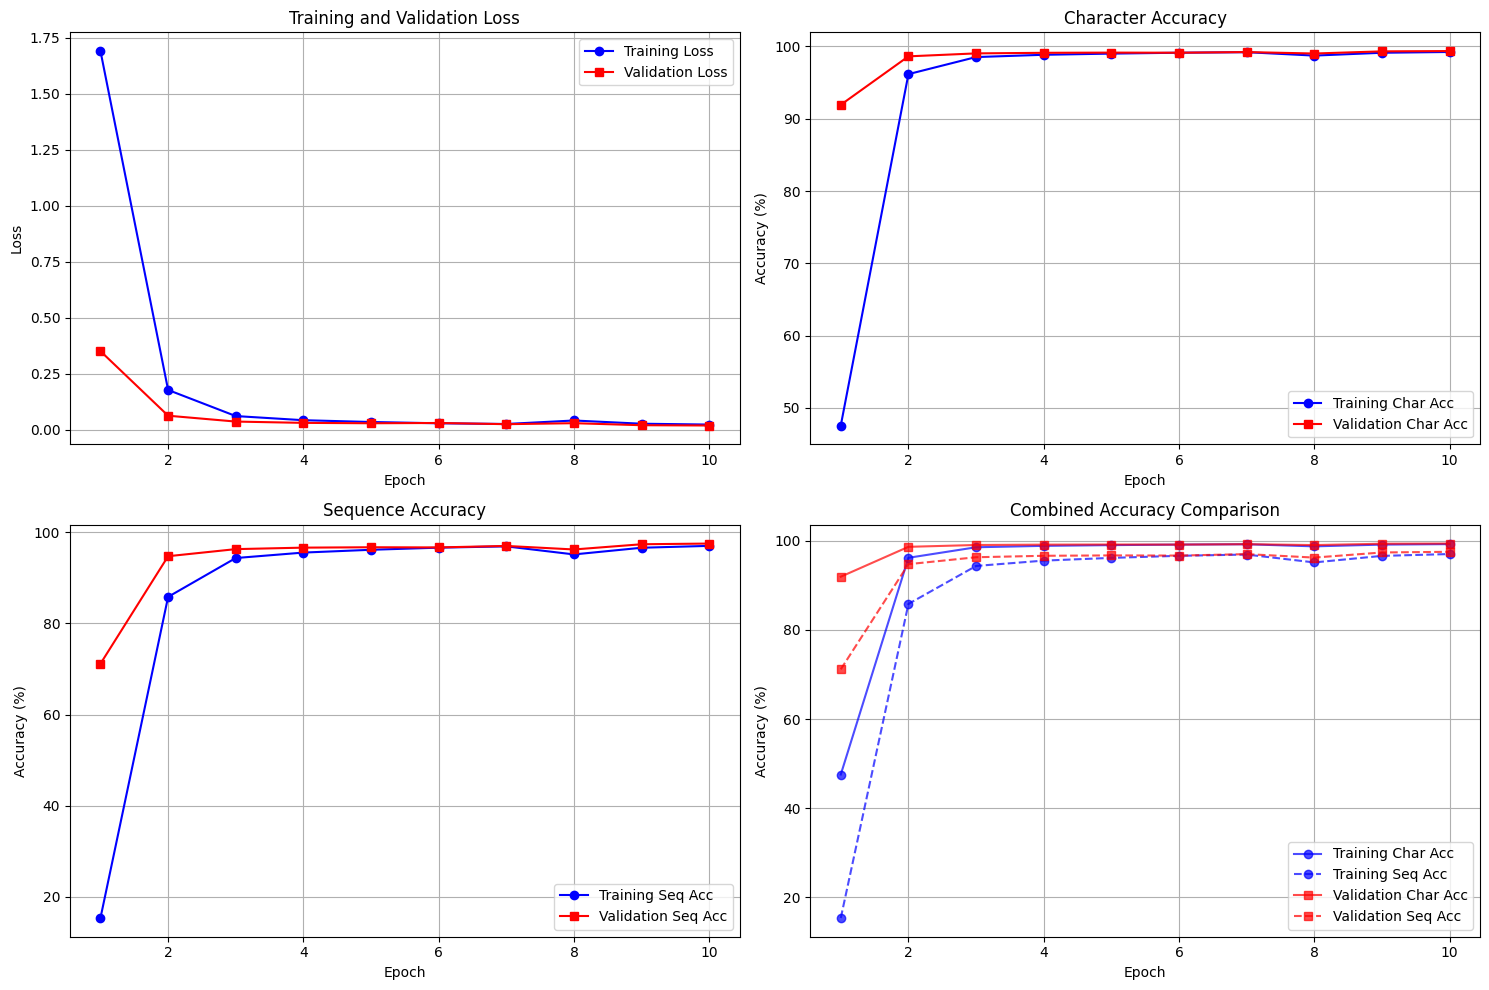

Final Training Metrics:
  Loss: 0.0232
  Character Accuracy: 99.24%
  Sequence Accuracy: 97.01%

Final Validation Metrics:
  Loss: 0.0190
  Character Accuracy: 99.37%
  Sequence Accuracy: 97.52%


In [36]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(checkpoints_dir='checkpoints', val_epoch=VAL_EPOCH):
    """
    Plot training and validation metrics from saved checkpoints
    """
    epochs = []
    train_losses = []
    train_char_acc = []
    train_seq_acc = []
    val_losses = []
    val_char_acc = []
    val_seq_acc = []

    # Find all checkpoint files
    checkpoint_files = []
    for f in os.listdir(checkpoints_dir):
        if f.startswith('epoch_') and f.endswith('.pth') and f != 'interrupted_epoch.pth':
            checkpoint_files.append(f)

    # Sort by epoch number
    checkpoint_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))

    # Extract data from each checkpoint
    for checkpoint_file in checkpoint_files:
        epoch_num = int(checkpoint_file.split('_')[1].split('.')[0])
        checkpoint_path = os.path.join(checkpoints_dir, checkpoint_file)

        checkpoint = torch.load(checkpoint_path, map_location='cpu')

        epochs.append(epoch_num)
        train_losses.append(checkpoint['train_loss'])
        train_char_acc.append(checkpoint['train_char_acc'])
        train_seq_acc.append(checkpoint['train_seq_acc'])

        # Only add validation data if it exists for this epoch
        if checkpoint['val_loss'] is not None:
            val_losses.append(checkpoint['val_loss'])
            val_char_acc.append(checkpoint['val_char_acc'])
            val_seq_acc.append(checkpoint['val_seq_acc'])

    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Training and Validation Loss
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', marker='o')
    if val_losses:
        val_epochs = epochs[::val_epoch] if val_epoch > 1 else epochs
        ax1.plot(val_epochs[:len(val_losses)], val_losses, 'r-', label='Validation Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Character Accuracy
    ax2.plot(epochs, train_char_acc, 'b-', label='Training Char Acc', marker='o')
    if val_char_acc:
        val_epochs = epochs[::val_epoch] if val_epoch > 1 else epochs
        ax2.plot(val_epochs[:len(val_char_acc)], val_char_acc, 'r-', label='Validation Char Acc', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Character Accuracy')
    ax2.legend()
    ax2.grid(True)

    # Plot 3: Sequence Accuracy
    ax3.plot(epochs, train_seq_acc, 'b-', label='Training Seq Acc', marker='o')
    if val_seq_acc:
        val_epochs = epochs[::val_epoch] if val_epoch > 1 else epochs
        ax3.plot(val_epochs[:len(val_seq_acc)], val_seq_acc, 'r-', label='Validation Seq Acc', marker='s')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy (%)')
    ax3.set_title('Sequence Accuracy')
    ax3.legend()
    ax3.grid(True)

    # Plot 4: Combined Accuracy
    ax4.plot(epochs, train_char_acc, 'b-', label='Training Char Acc', marker='o', alpha=0.7)
    ax4.plot(epochs, train_seq_acc, 'b--', label='Training Seq Acc', marker='o', alpha=0.7)
    if val_char_acc and val_seq_acc:
        val_epochs = epochs[::val_epoch] if val_epoch > 1 else epochs
        ax4.plot(val_epochs[:len(val_char_acc)], val_char_acc, 'r-', label='Validation Char Acc', marker='s', alpha=0.7)
        ax4.plot(val_epochs[:len(val_seq_acc)], val_seq_acc, 'r--', label='Validation Seq Acc', marker='s', alpha=0.7)
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy (%)')
    ax4.set_title('Combined Accuracy Comparison')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print(f"Final Training Metrics:")
    print(f"  Loss: {train_losses[-1]:.4f}")
    print(f"  Character Accuracy: {train_char_acc[-1]:.2f}%")
    print(f"  Sequence Accuracy: {train_seq_acc[-1]:.2f}%")

    if val_losses:
        print(f"\nFinal Validation Metrics:")
        print(f"  Loss: {val_losses[-1]:.4f}")
        print(f"  Character Accuracy: {val_char_acc[-1]:.2f}%")
        print(f"  Sequence Accuracy: {val_seq_acc[-1]:.2f}%")

# Plot the training history
plot_training_history()

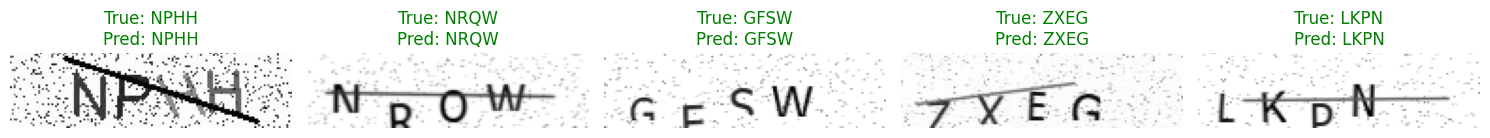

In [37]:
def visualize_predictions(model, dataloader, num_samples=5, char_to_idx=char_to_idx):
    """
    Visualize model predictions on sample images
    """
    model.eval()
    idx_to_char = {v: k for k, v in char_to_idx.items()}

    # Get some samples
    samples = []
    for X, y in dataloader:
        samples.append((X, y))
        if len(samples) >= num_samples:
            break

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    if num_samples == 1:
        axes = [axes]

    for i, (X, y) in enumerate(samples):
        if i >= num_samples:
            break

        X, y = X.to(device), y.to(device)

        with torch.no_grad():
            preds = model(X)
            pred_classes = torch.argmax(preds, dim=2)

        # Convert to strings
        true_label = ''.join([idx_to_char[char_idx.item()] for char_idx in y[0]])
        pred_label = ''.join([idx_to_char[char_idx.item()] for char_idx in pred_classes[0]])

        # Plot image
        img = X[0].cpu().squeeze().numpy()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}')
        axes[i].axis('off')

        # Color title based on correctness
        color = 'green' if true_label == pred_label else 'red'
        axes[i].title.set_color(color)

    plt.tight_layout()
    plt.show()

# Visualize predictions on validation set
visualize_predictions(model, val_loader, num_samples=5)

In [38]:
def print_model_summary(model):
    """
    Print model architecture and parameter count
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Model Architecture:")
    print(model)
    print(f"\nTotal Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")

# Print model summary
print_model_summary(model)

Model Architecture:
CaptchaCrackNet(
  (affn): AFFN()
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (crnn): CRNN(
    (conv1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, st

🔍 Comprehensive Model Analysis

📦 Model Size: 4.66 MB
📊 Parameters: 1,221,133 total, 1,221,133 trainable

💾 Memory Usage:
   RAM: 1.90/12.67 GB (15.0%)
   GPU: 0.041/14.74 GB (0.3%)

⏱️  Measuring Latency...
   Average: 5.87 ms
   Minimum: 5.08 ms
   Maximum: 40.53 ms
   P95: 7.21 ms
   FPS: 170.4 frames/second

❌ Analyzing Failed Predictions...


Finding failed predictions: 100%|██████████| 1157/1157 [01:30<00:00, 12.82it/s]


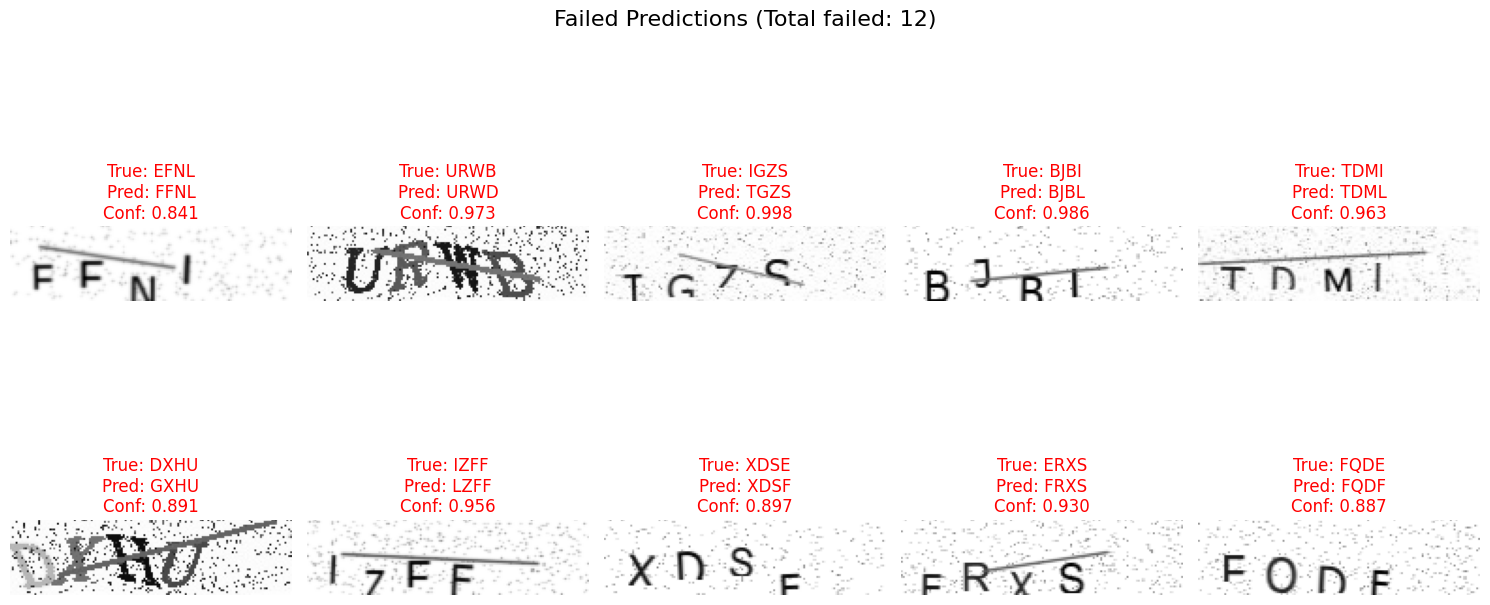


📊 Failed Predictions Analysis:
Total failed samples found: 12

🔠 Most common character errors:
  I→L: 5 times
  E→F: 4 times
  B→D: 1 times
  I→T: 1 times
  D→G: 1 times

🏗️  Layer-wise Information:
   affn: 3 parameters
   conv1: 832 parameters
   conv2: 38,448 parameters
   conv3: 76,864 parameters
   res: 832 parameters
   crnn: 1,104,154 parameters


Testing accuracy: 100%|██████████| 1157/1157 [01:23<00:00, 13.81it/s]


🎯 Final Accuracy Results:
   Character Accuracy: 99.37%
   Sequence Accuracy: 97.52%


In [40]:
import random
import time
import psutil
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

def analyze_failed_predictions(model, dataloader, char_to_idx, num_samples=10):
    """
    Analyze and display failed predictions randomly
    """
    model.eval()
    idx_to_char = {v: k for k, v in char_to_idx.items()}

    # Collect all failed predictions
    failed_samples = []

    with torch.no_grad():
        for X, y in tqdm(dataloader, desc="Finding failed predictions"):
            X, y = X.to(device), y.to(device)
            preds = model(X)
            pred_classes = torch.argmax(preds, dim=2)

            for i in range(X.size(0)):
                true_label = ''.join([idx_to_char[char_idx.item()] for char_idx in y[i]])
                pred_label = ''.join([idx_to_char[char_idx.item()] for char_idx in pred_classes[i]])

                if true_label != pred_label:
                    confidence = torch.softmax(preds[i], dim=1).max(dim=1).values.mean().item()
                    failed_samples.append({
                        'image': X[i].cpu(),
                        'true_label': true_label,
                        'pred_label': pred_label,
                        'confidence': confidence
                    })

    # Select random failed samples
    if len(failed_samples) > num_samples:
        failed_samples = random.sample(failed_samples, num_samples)

    # Plot failed predictions
    if failed_samples:
        fig, axes = plt.subplots(2, min(5, len(failed_samples)//2 + 1), figsize=(15, 8))
        axes = axes.flatten()

        for i, sample in enumerate(failed_samples):
            if i >= len(axes):
                break

            img = sample['image'].squeeze().numpy()
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f'True: {sample["true_label"]}\nPred: {sample["pred_label"]}\nConf: {sample["confidence"]:.3f}')
            axes[i].axis('off')
            axes[i].title.set_color('red')

        # Hide empty subplots
        for i in range(len(failed_samples), len(axes)):
            axes[i].axis('off')

        plt.suptitle(f'Failed Predictions (Total failed: {len(failed_samples)})', fontsize=16)
        plt.tight_layout()
        plt.show()

        # Print detailed analysis
        print(f"\n📊 Failed Predictions Analysis:")
        print(f"Total failed samples found: {len(failed_samples)}")

        # Character error analysis
        char_errors = {}
        for sample in failed_samples:
            for true_char, pred_char in zip(sample['true_label'], sample['pred_label']):
                if true_char != pred_char:
                    error_key = f"{true_char}→{pred_char}"
                    char_errors[error_key] = char_errors.get(error_key, 0) + 1

        if char_errors:
            print(f"\n🔠 Most common character errors:")
            sorted_errors = sorted(char_errors.items(), key=lambda x: x[1], reverse=True)
            for error, count in sorted_errors[:10]:  # Top 10 errors
                print(f"  {error}: {count} times")

    else:
        print("🎉 No failed predictions found!")

def get_model_size(model):
    """
    Calculate model size in MB
    """
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()

    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

def get_memory_usage():
    """
    Get current RAM and GPU memory usage
    """
    # RAM usage
    ram = psutil.virtual_memory()
    ram_used = ram.used / 1024**3  # GB
    ram_total = ram.total / 1024**3  # GB

    # GPU memory usage
    gpu_used = 0
    gpu_total = 0
    if torch.cuda.is_available():
        gpu_used = torch.cuda.memory_allocated() / 1024**3  # GB
        gpu_total = torch.cuda.get_device_properties(0).total_memory / 1024**3  # GB

    return {
        'ram_used_gb': ram_used,
        'ram_total_gb': ram_total,
        'ram_usage_percent': (ram_used / ram_total) * 100,
        'gpu_used_gb': gpu_used,
        'gpu_total_gb': gpu_total,
        'gpu_usage_percent': (gpu_used / gpu_total) * 100 if gpu_total > 0 else 0
    }

def measure_latency(model, input_size=(1, 1, 40, 150), num_runs=100, warmup=10):
    """
    Measure inference latency
    """
    model.eval()

    # Create dummy input
    dummy_input = torch.randn(input_size).to(device)

    # Warmup
    with torch.no_grad():
        for _ in range(warmup):
            _ = model(dummy_input)

    # Measure latency
    latencies = []
    with torch.no_grad():
        for _ in range(num_runs):
            start_time = time.time()
            _ = model(dummy_input)
            if torch.cuda.is_available():
                torch.cuda.synchronize()  # Wait for GPU operations to complete
            end_time = time.time()
            latencies.append((end_time - start_time) * 1000)  # Convert to milliseconds

    # Calculate statistics
    avg_latency = sum(latencies) / len(latencies)
    min_latency = min(latencies)
    max_latency = max(latencies)
    p95_latency = sorted(latencies)[int(0.95 * len(latencies))]

    return {
        'avg_latency_ms': avg_latency,
        'min_latency_ms': min_latency,
        'max_latency_ms': max_latency,
        'p95_latency_ms': p95_latency,
        'fps': 1000 / avg_latency  # Frames per second
    }

def comprehensive_model_analysis(model, dataloader, char_to_idx):
    """
    Comprehensive analysis of the model
    """
    print("🔍 Comprehensive Model Analysis")
    print("=" * 50)

    # 1. Model Size
    model_size_mb = get_model_size(model)
    print(f"\n📦 Model Size: {model_size_mb:.2f} MB")

    # 2. Parameter Count
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"📊 Parameters: {total_params:,} total, {trainable_params:,} trainable")

    # 3. Memory Usage
    mem_info = get_memory_usage()
    print(f"\n💾 Memory Usage:")
    print(f"   RAM: {mem_info['ram_used_gb']:.2f}/{mem_info['ram_total_gb']:.2f} GB ({mem_info['ram_usage_percent']:.1f}%)")
    if torch.cuda.is_available():
        print(f"   GPU: {mem_info['gpu_used_gb']:.3f}/{mem_info['gpu_total_gb']:.2f} GB ({mem_info['gpu_usage_percent']:.1f}%)")

    # 4. Latency
    print(f"\n⏱️  Measuring Latency...")
    latency_info = measure_latency(model)
    print(f"   Average: {latency_info['avg_latency_ms']:.2f} ms")
    print(f"   Minimum: {latency_info['min_latency_ms']:.2f} ms")
    print(f"   Maximum: {latency_info['max_latency_ms']:.2f} ms")
    print(f"   P95: {latency_info['p95_latency_ms']:.2f} ms")
    print(f"   FPS: {latency_info['fps']:.1f} frames/second")

    # 5. Failed Predictions Analysis
    print(f"\n❌ Analyzing Failed Predictions...")
    analyze_failed_predictions(model, dataloader, char_to_idx, num_samples=12)

    # 6. Layer-wise Analysis
    print(f"\n🏗️  Layer-wise Information:")
    for name, module in model.named_children():
        num_params = sum(p.numel() for p in module.parameters())
        print(f"   {name}: {num_params:,} parameters")

    return {
        'model_size_mb': model_size_mb,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'memory_info': mem_info,
        'latency_info': latency_info
    }

# Run comprehensive analysis
analysis_results = comprehensive_model_analysis(model, val_loader, char_to_idx)

# Additional: Test on a batch to get accuracy metrics
def test_model_accuracy(model, dataloader):
    """
    Test model accuracy on the entire dataset
    """
    model.eval()
    char_correct = 0
    char_total = 0
    seq_correct = 0
    seq_total = 0

    with torch.no_grad():
        for X, y in tqdm(dataloader, desc="Testing accuracy"):
            X, y = X.to(device), y.to(device)
            preds = model(X)
            pred_classes = torch.argmax(preds, dim=2)

            char_correct += (pred_classes == y).sum().item()
            char_total += y.numel()
            seq_correct += (pred_classes == y).all(dim=1).sum().item()
            seq_total += y.size(0)

    char_acc = char_correct / char_total * 100
    seq_acc = seq_correct / seq_total * 100

    print(f"\n🎯 Final Accuracy Results:")
    print(f"   Character Accuracy: {char_acc:.2f}%")
    print(f"   Sequence Accuracy: {seq_acc:.2f}%")

    return char_acc, seq_acc

# Test accuracy
char_acc, seq_acc = test_model_accuracy(model, val_loader)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files
import zipfile
import os

# 1. Upload dataset to Colab
def upload_and_extract_dataset():
    """Upload and extract dataset in Colab"""
    print("📤 Upload your dataset (zip file containing images)")
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded. Using existing data directory.")
        return DATA_DIR

    # Get the uploaded file
    zip_filename = list(uploaded.keys())[0]

    # Create extraction directory
    extract_dir = "/content/uploaded_dataset"
    os.makedirs(extract_dir, exist_ok=True)

    # Extract zip file
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    print(f"✅ Dataset extracted to: {extract_dir}")
    return extract_dir

# Upload new dataset (uncomment to use)
NEW_DATA_DIR = upload_and_extract_dataset()
train_loader_new, val_loader_new, char_to_idx_new = get_dataloaders(NEW_DATA_DIR, batch_size=64, val_split=0.2)

📤 Upload your dataset (zip file containing images)


In [ ]:
model=CaptchaCrackNet().to(device)
optimizer=torch.optim.Adam(model.parameters())

In [ ]:
train_history,val_history=train(model,train_loader,val_loader,optimizer,nn.CrossEntropyLoss(),EPOCHS)


📌 Epoch 1:


Training: 100%|██████████| 4627/4627 [27:33<00:00,  2.80it/s]


Train Loss: 1.6903, Char Acc: 47.56%, Seq Acc: 15.38%


Validation: 100%|██████████| 1157/1157 [01:20<00:00, 14.41it/s]


Validation Loss: 0.3509, Char Acc: 91.93%, Seq Acc: 71.16%
✅ Model saved: checkpoints/epoch_1.pth

📌 Epoch 2:


Training: 100%|██████████| 4627/4627 [27:35<00:00,  2.80it/s]


Train Loss: 0.1776, Char Acc: 96.17%, Seq Acc: 85.82%


Validation: 100%|██████████| 1157/1157 [01:20<00:00, 14.38it/s]


Validation Loss: 0.0627, Char Acc: 98.63%, Seq Acc: 94.74%
✅ Model saved: checkpoints/epoch_2.pth

📌 Epoch 3:


Training: 100%|██████████| 4627/4627 [27:35<00:00,  2.79it/s]


Train Loss: 0.0611, Char Acc: 98.54%, Seq Acc: 94.34%


Validation: 100%|██████████| 1157/1157 [01:20<00:00, 14.40it/s]


Validation Loss: 0.0366, Char Acc: 99.04%, Seq Acc: 96.30%
✅ Model saved: checkpoints/epoch_3.pth

📌 Epoch 4:


Training: 100%|██████████| 4627/4627 [27:37<00:00,  2.79it/s]


Train Loss: 0.0427, Char Acc: 98.85%, Seq Acc: 95.54%


Validation: 100%|██████████| 1157/1157 [01:20<00:00, 14.41it/s]


Validation Loss: 0.0307, Char Acc: 99.12%, Seq Acc: 96.62%
✅ Model saved: checkpoints/epoch_4.pth

📌 Epoch 5:


Training: 100%|██████████| 4627/4627 [27:36<00:00,  2.79it/s]


Train Loss: 0.0346, Char Acc: 99.01%, Seq Acc: 96.15%


Validation: 100%|██████████| 1157/1157 [01:20<00:00, 14.39it/s]


Validation Loss: 0.0290, Char Acc: 99.15%, Seq Acc: 96.71%
✅ Model saved: checkpoints/epoch_5.pth

📌 Epoch 6:


Training: 100%|██████████| 4627/4627 [27:35<00:00,  2.80it/s]


Train Loss: 0.0289, Char Acc: 99.14%, Seq Acc: 96.62%


Validation: 100%|██████████| 1157/1157 [01:20<00:00, 14.38it/s]


Validation Loss: 0.0303, Char Acc: 99.14%, Seq Acc: 96.67%
✅ Model saved: checkpoints/epoch_6.pth

📌 Epoch 7:


Training: 100%|██████████| 4627/4627 [27:35<00:00,  2.80it/s]


Train Loss: 0.0258, Char Acc: 99.21%, Seq Acc: 96.90%


Validation: 100%|██████████| 1157/1157 [01:20<00:00, 14.44it/s]


Validation Loss: 0.0249, Char Acc: 99.23%, Seq Acc: 97.00%
✅ Model saved: checkpoints/epoch_7.pth

📌 Epoch 8:


Training: 100%|██████████| 4627/4627 [27:35<00:00,  2.80it/s]


Train Loss: 0.0234, Char Acc: 99.26%, Seq Acc: 97.12%


Validation: 100%|██████████| 1157/1157 [01:20<00:00, 14.35it/s]


Validation Loss: 0.0225, Char Acc: 99.32%, Seq Acc: 97.33%
✅ Model saved: checkpoints/epoch_8.pth

📌 Epoch 9:


Training: 100%|██████████| 4627/4627 [27:26<00:00,  2.81it/s]


Train Loss: 0.0210, Char Acc: 99.32%, Seq Acc: 97.33%


Validation: 100%|██████████| 1157/1157 [01:19<00:00, 14.50it/s]


Validation Loss: 0.0218, Char Acc: 99.32%, Seq Acc: 97.35%
✅ Model saved: checkpoints/epoch_9.pth

📌 Epoch 10:


Training:  50%|█████     | 2329/4627 [13:47<13:41,  2.80it/s]

In [ ]:
import glob

# Check for existing checkpoints
checkpoints = glob.glob('checkpoints/*.pth')
if checkpoints:
    print("Found checkpoints:")
    for cp in sorted(checkpoints):
        print(f"  - {cp}")

    # Load the latest checkpoint
    latest_checkpoint = max(checkpoints, key=os.path.getctime)
    print(f"Loading latest checkpoint: {latest_checkpoint}")

    checkpoint = torch.load(latest_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming from epoch {start_epoch}")
else:
    print("No checkpoints found, starting from scratch")
    start_epoch = 1

No checkpoints found, starting from scratch


In [ ]:
# Run training with auto-save every epoch
train_history, val_history = train(model, train_loader, val_loader, optimizer, nn.CrossEntropyLoss(), EPOCHS)

Epoch 1:


Training:  10%|█         | 681/6746 [06:46<1:00:19,  1.68it/s]


KeyboardInterrupt: 

In [ ]:
# Load the last saved model
model.load_state_dict(torch.load('final.pth'))
print("Loaded final model!")

RuntimeError: Error(s) in loading state_dict for CaptchaCrackNet:
	Missing key(s) in state_dict: "conv1.0.weight", "conv1.0.bias", "conv2.0.weight", "conv2.0.bias", "conv3.0.weight", "conv3.0.bias", "res.weight", "res.bias". 
	size mismatch for affn.alpha: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([3]).
	size mismatch for crnn.conv1.0.weight: copying a param with shape torch.Size([2, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 64, 5, 5]).
	size mismatch for crnn.conv1.0.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for crnn.conv1.1.weight: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for crnn.conv1.1.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for crnn.conv1.1.running_mean: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for crnn.conv1.1.running_var: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for crnn.conv2.0.weight: copying a param with shape torch.Size([4, 2, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 128, 5, 5]).
	size mismatch for crnn.conv2.0.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for crnn.conv2.1.weight: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for crnn.conv2.1.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for crnn.conv2.1.running_mean: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for crnn.conv2.1.running_var: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for crnn.latent_fc.weight: copying a param with shape torch.Size([128, 1716]) from checkpoint, the shape in current model is torch.Size([64, 1024]).
	size mismatch for crnn.latent_fc.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for crnn.lstm.weight_ih_l0: copying a param with shape torch.Size([1024, 128]) from checkpoint, the shape in current model is torch.Size([128, 64]).
	size mismatch for crnn.lstm.weight_hh_l0: copying a param with shape torch.Size([1024, 256]) from checkpoint, the shape in current model is torch.Size([128, 32]).
	size mismatch for crnn.lstm.bias_ih_l0: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for crnn.lstm.bias_hh_l0: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for crnn.output_fc.weight: copying a param with shape torch.Size([26, 256]) from checkpoint, the shape in current model is torch.Size([26, 32]).

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, data_loader, device):
    """
    Comprehensive evaluation with all metrics
    """
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X, y in tqdm(data_loader, desc="Evaluating"):
            X = X.to(device)
            y = y.to(device)
            preds = model(X)

            # Get predicted characters
            preds_class = torch.argmax(preds, dim=2)  # (batch_size, 4)

            all_preds.extend(preds_class.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Flatten for character-level metrics
    preds_flat = all_preds.flatten()
    targets_flat = all_targets.flatten()

    return all_preds, all_targets, preds_flat, targets_flat

def calculate_metrics(preds_flat, targets_flat, preds, targets):
    """
    Calculate all evaluation metrics
    """
    # Character-level metrics
    char_accuracy = accuracy_score(targets_flat, preds_flat)
    char_precision = precision_score(targets_flat, preds_flat, average='weighted', zero_division=0)
    char_recall = recall_score(targets_flat, preds_flat, average='weighted', zero_division=0)
    char_f1 = f1_score(targets_flat, preds_flat, average='weighted', zero_division=0)

    # CAPTCHA-level accuracy (all 4 characters correct)
    captcha_correct = np.all(preds == targets, axis=1)
    captcha_accuracy = np.mean(captcha_correct) * 100

    return {
        'char_accuracy': char_accuracy,
        'char_precision': char_precision,
        'char_recall': char_recall,
        'char_f1': char_f1,
        'captcha_accuracy': captcha_accuracy,
        'preds_flat': preds_flat,
        'targets_flat': targets_flat,
        'captcha_correct': captcha_correct
    }

def print_detailed_report(metrics, targets_flat):
    """
    Print comprehensive evaluation report
    """
    print("🎯 COMPREHENSIVE EVALUATION METRICS")
    print("=" * 50)

    print(f"\n📊 CHARACTER-LEVEL METRICS:")
    print(f"Accuracy:  {metrics['char_accuracy']:.4f} ({metrics['char_accuracy']*100:.2f}%)")
    print(f"Precision: {metrics['char_precision']:.4f}")
    print(f"Recall:    {metrics['char_recall']:.4f}")
    print(f"F1 Score:  {metrics['char_f1']:.4f}")

    print(f"\n🎯 CAPTCHA-LEVEL METRICS:")
    print(f"Full CAPTCHA Accuracy: {metrics['captcha_accuracy']:.2f}%")
    print(f"({np.sum(metrics['captcha_correct'])}/{len(metrics['captcha_correct'])} complete CAPTCHAs correct)")

    print(f"\n📈 CLASS DISTRIBUTION:")
    unique, counts = np.unique(targets_flat, return_counts=True)
    for char_idx, count in zip(unique, counts):
        print(f"Class {char_idx:2d}: {count:4d} samples")

In [ ]:
def plot_confusion_matrix(targets_flat, preds_flat):
    """
    Plot detailed confusion matrix
    """
    # Convert indices to letters
    characters = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    target_letters = [characters[i] for i in targets_flat]
    pred_letters = [characters[i] for i in preds_flat]

    # Create confusion matrix
    cm = confusion_matrix(target_letters, pred_letters, labels=characters)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=characters, yticklabels=characters)
    plt.title('Confusion Matrix - Character Level')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

🧪 Evaluating on Validation Set...


Evaluating: 100%|██████████| 1157/1157 [00:45<00:00, 25.60it/s]


🎯 COMPREHENSIVE EVALUATION METRICS

📊 CHARACTER-LEVEL METRICS:
Accuracy:  0.6815 (68.15%)
Precision: 0.6807
Recall:    0.6815
F1 Score:  0.6796

🎯 CAPTCHA-LEVEL METRICS:
Full CAPTCHA Accuracy: 23.93%
(17715/74028 complete CAPTCHAs correct)

📈 CLASS DISTRIBUTION:
Class  0: 13202 samples
Class  1: 13169 samples
Class  2: 13029 samples
Class  3: 13067 samples
Class  4: 12818 samples
Class  5: 11483 samples
Class  6: 10761 samples
Class  7: 10609 samples
Class  8: 8926 samples
Class  9: 8912 samples
Class 10: 10381 samples
Class 11: 9016 samples
Class 12: 10330 samples
Class 13: 12772 samples
Class 14: 9104 samples
Class 15: 12985 samples
Class 16: 8989 samples
Class 17: 13130 samples
Class 18: 9046 samples
Class 19: 13390 samples
Class 20: 13190 samples
Class 21: 11829 samples
Class 22: 11196 samples
Class 23: 12352 samples
Class 24: 13325 samples
Class 25: 9101 samples


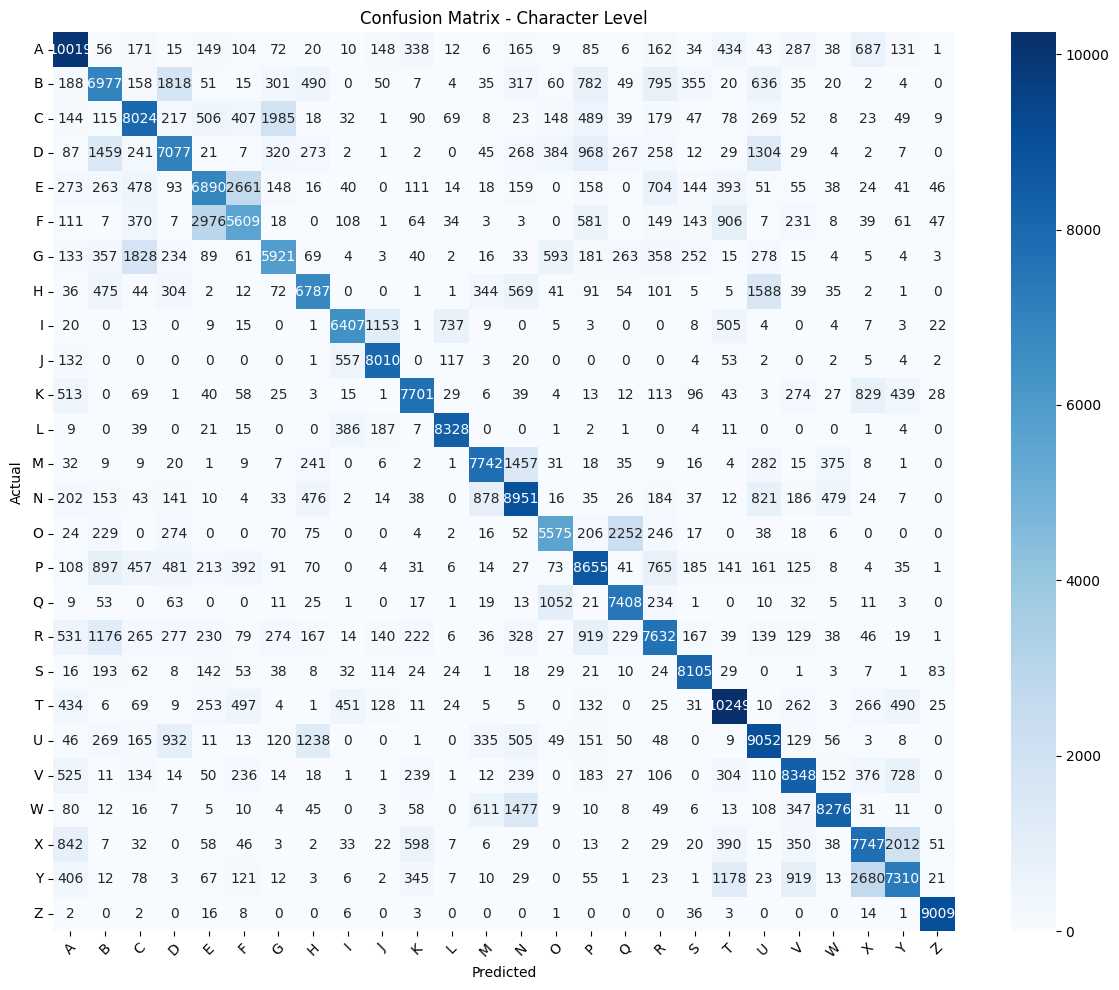


🧪 Evaluating on Training Set (for overfitting check)...


Evaluating: 100%|██████████| 4627/4627 [02:42<00:00, 28.55it/s]


🎯 COMPREHENSIVE EVALUATION METRICS

📊 CHARACTER-LEVEL METRICS:
Accuracy:  0.7034 (70.34%)
Precision: 0.7025
Recall:    0.7034
F1 Score:  0.7015

🎯 CAPTCHA-LEVEL METRICS:
Full CAPTCHA Accuracy: 26.81%
(79384/296112 complete CAPTCHAs correct)

📈 CLASS DISTRIBUTION:
Class  0: 52556 samples
Class  1: 52507 samples
Class  2: 52343 samples
Class  3: 51680 samples
Class  4: 51430 samples
Class  5: 45575 samples
Class  6: 43313 samples
Class  7: 41826 samples
Class  8: 36137 samples
Class  9: 36249 samples
Class 10: 41806 samples
Class 11: 36262 samples
Class 12: 41915 samples
Class 13: 51122 samples
Class 14: 36045 samples
Class 15: 52316 samples
Class 16: 36213 samples
Class 17: 52608 samples
Class 18: 36153 samples
Class 19: 52762 samples
Class 20: 52934 samples
Class 21: 47427 samples
Class 22: 44928 samples
Class 23: 49724 samples
Class 24: 52837 samples
Class 25: 35780 samples


In [ ]:
# Evaluate on validation set
print("🧪 Evaluating on Validation Set...")
val_preds, val_targets, val_preds_flat, val_targets_flat = evaluate_model(model, val_loader, device)
val_metrics = calculate_metrics(val_preds_flat, val_targets_flat, val_preds, val_targets)

print_detailed_report(val_metrics, val_targets_flat)
plot_confusion_matrix(val_targets_flat, val_preds_flat)

# Evaluate on training set (to check for overfitting)
print("\n" + "="*50)
print("🧪 Evaluating on Training Set (for overfitting check)...")
train_preds, train_targets, train_preds_flat, train_targets_flat = evaluate_model(model, train_loader, device)
train_metrics = calculate_metrics(train_preds_flat, train_targets_flat, train_preds, train_targets)

print_detailed_report(train_metrics, train_targets_flat)

In [ ]:
def analyze_errors(preds, targets, data_loader):
    """
    Analyze which CAPTCHAs are being misclassified
    """
    characters = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

    incorrect_indices = np.where(~np.all(preds == targets, axis=1))[0]

    print(f"\n🔍 ERROR ANALYSIS ({len(incorrect_indices)} incorrect CAPTCHAs):")

    for i in incorrect_indices[:10]:  # Show first 10 errors
        actual = ''.join([characters[idx] for idx in targets[i]])
        predicted = ''.join([characters[idx] for idx in preds[i]])
        print(f"Actual: {actual} | Predicted: {predicted} | Errors: {sum(targets[i] != preds[i])}")

    # Most common error patterns
    error_positions = []
    for i in incorrect_indices:
        error_mask = targets[i] != preds[i]
        error_positions.extend(np.where(error_mask)[0])

    print(f"\n📊 Most common error positions: {np.bincount(error_positions)}")

Evaluating: 100%|██████████| 1157/1157 [00:40<00:00, 28.33it/s]


🎯 COMPREHENSIVE EVALUATION METRICS

📊 CHARACTER-LEVEL METRICS:
Accuracy:  0.6815 (68.15%)
Precision: 0.6807
Recall:    0.6815
F1 Score:  0.6796

🎯 CAPTCHA-LEVEL METRICS:
Full CAPTCHA Accuracy: 23.93%
(17715/74028 complete CAPTCHAs correct)

📈 CLASS DISTRIBUTION:
Class  0: 13202 samples
Class  1: 13169 samples
Class  2: 13029 samples
Class  3: 13067 samples
Class  4: 12818 samples
Class  5: 11483 samples
Class  6: 10761 samples
Class  7: 10609 samples
Class  8: 8926 samples
Class  9: 8912 samples
Class 10: 10381 samples
Class 11: 9016 samples
Class 12: 10330 samples
Class 13: 12772 samples
Class 14: 9104 samples
Class 15: 12985 samples
Class 16: 8989 samples
Class 17: 13130 samples
Class 18: 9046 samples
Class 19: 13390 samples
Class 20: 13190 samples
Class 21: 11829 samples
Class 22: 11196 samples
Class 23: 12352 samples
Class 24: 13325 samples
Class 25: 9101 samples


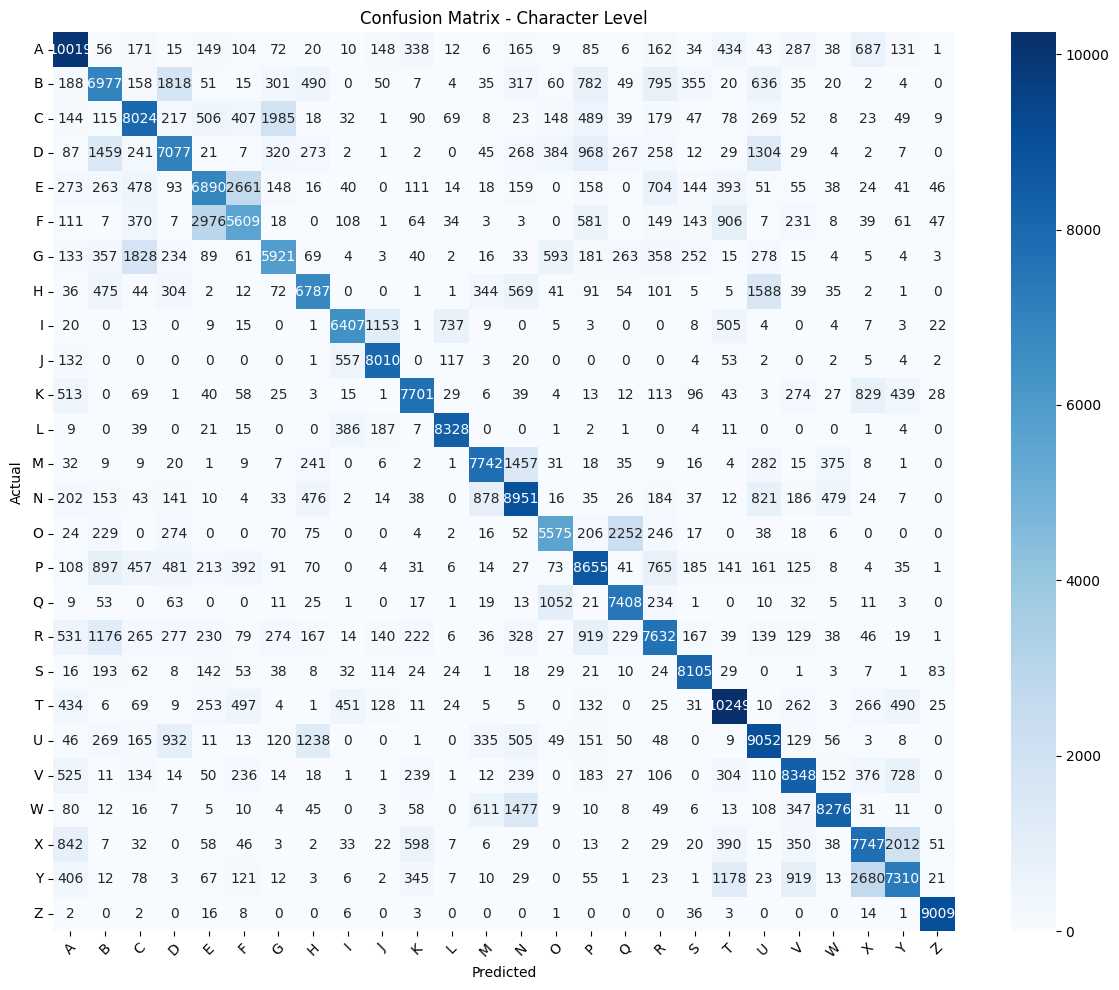


🔍 ERROR ANALYSIS (56313 incorrect CAPTCHAs):
Actual: UBII | Predicted: DHIL | Errors: 3
Actual: NUJP | Predicted: NUJR | Errors: 1
Actual: OOPG | Predicted: QOKO | Errors: 3
Actual: YFXN | Predicted: YFXU | Errors: 1
Actual: DXVZ | Predicted: DAVZ | Errors: 1
Actual: OTZR | Predicted: BTZR | Errors: 1
Actual: QWZZ | Predicted: QVZZ | Errors: 1
Actual: NXCM | Predicted: RTGM | Errors: 3
Actual: UADE | Predicted: UADC | Errors: 1
Actual: CNGR | Predicted: PNNA | Errors: 3

📊 Most common error positions: [20516 23038 24796 25953]

OVERFITTING CHECK (Train vs Validation):
Training Accuracy:    70.34%
Validation Accuracy:  68.15%
Difference:           2.19%
✅ No significant overfitting detected!


In [ ]:
# Load your best model
model.load_state_dict(torch.load('final.pth'))

# Complete evaluation
val_preds, val_targets, val_preds_flat, val_targets_flat = evaluate_model(model, val_loader, device)
val_metrics = calculate_metrics(val_preds_flat, val_targets_flat, val_preds, val_targets)

print_detailed_report(val_metrics, val_targets_flat)
plot_confusion_matrix(val_targets_flat, val_preds_flat)
analyze_errors(val_preds, val_targets, val_loader)

# Check for overfitting
print("\n" + "="*50)
print("OVERFITTING CHECK (Train vs Validation):")
print(f"Training Accuracy:    {train_metrics['char_accuracy']*100:.2f}%")
print(f"Validation Accuracy:  {val_metrics['char_accuracy']*100:.2f}%")
print(f"Difference:           {abs(train_metrics['char_accuracy'] - val_metrics['char_accuracy'])*100:.2f}%")

if abs(train_metrics['char_accuracy'] - val_metrics['char_accuracy']) > 0.05:
    print("⚠️  Warning: Possible overfitting detected!")
else:
    print("✅ No significant overfitting detected!")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import string

def visualize_predictions_fixed(model, data_loader, device, num_samples=10):
    """
    Fixed version: Properly separate correct and incorrect predictions
    """
    model.eval()
    characters = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

    correct_images = []
    correct_actuals = []
    correct_preds = []

    wrong_images = []
    wrong_actuals = []
    wrong_preds = []

    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            preds = model(X)
            preds_class = torch.argmax(preds, dim=2)

            # Convert to numpy
            X_np = X.cpu().numpy()
            y_np = y.cpu().numpy()
            preds_np = preds_class.cpu().numpy()

            for i in range(len(X)):
                actual_str = ''.join([characters[idx] for idx in y_np[i]])
                pred_str = ''.join([characters[idx] for idx in preds_np[i]])

                if actual_str == pred_str:
                    correct_images.append(X_np[i])
                    correct_actuals.append(actual_str)
                    correct_preds.append(pred_str)
                else:
                    wrong_images.append(X_np[i])
                    wrong_actuals.append(actual_str)
                    wrong_preds.append(pred_str)

            # Stop when we have enough samples
            if len(correct_images) >= num_samples and len(wrong_images) >= num_samples:
                break

    return (correct_images, correct_actuals, correct_preds,
            wrong_images, wrong_actuals, wrong_preds)

def plot_captcha_grid(images, actuals, predictions, title, num_samples=10):
    """
    Plot a grid of CAPTCHA images
    """
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    for idx, ax in enumerate(axes.flat):
        if idx < min(num_samples, len(images)):
            img = images[idx].squeeze()  # Remove channel dimension
            actual = actuals[idx]
            pred = predictions[idx]

            ax.imshow(img, cmap='gray')
            color = 'green' if actual == pred else 'red'
            ax.set_title(f"Actual: {actual}\nPred: {pred}",
                        color=color,
                        fontweight='bold',
                        fontsize=12)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

def plot_detailed_errors(wrong_images, wrong_actuals, wrong_preds, num_samples=10):
    """
    Show wrong predictions with character-level highlighting
    """
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    fig.suptitle('Detailed Wrong Predictions (Red characters are wrong)',
                fontsize=16, fontweight='bold')

    for idx, ax in enumerate(axes.flat):
        if idx < min(num_samples, len(wrong_images)):
            img = wrong_images[idx].squeeze()
            actual = wrong_actuals[idx]
            pred = wrong_preds[idx]

            # Create colored prediction text
            colored_pred = ""
            for a_char, p_char in zip(actual, pred):
                if a_char == p_char:
                    colored_pred += p_char
                else:
                    colored_pred += f"[{p_char}]"  # Highlight wrong chars

            ax.imshow(img, cmap='gray')
            ax.set_title(f"Actual: {actual}\nPred: {colored_pred}",
                        fontweight='bold',
                        fontsize=12)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

📸 Collecting predictions...
✅ Found 20 correct predictions
❌ Found 44 wrong predictions

🟢 CORRECT Predictions:


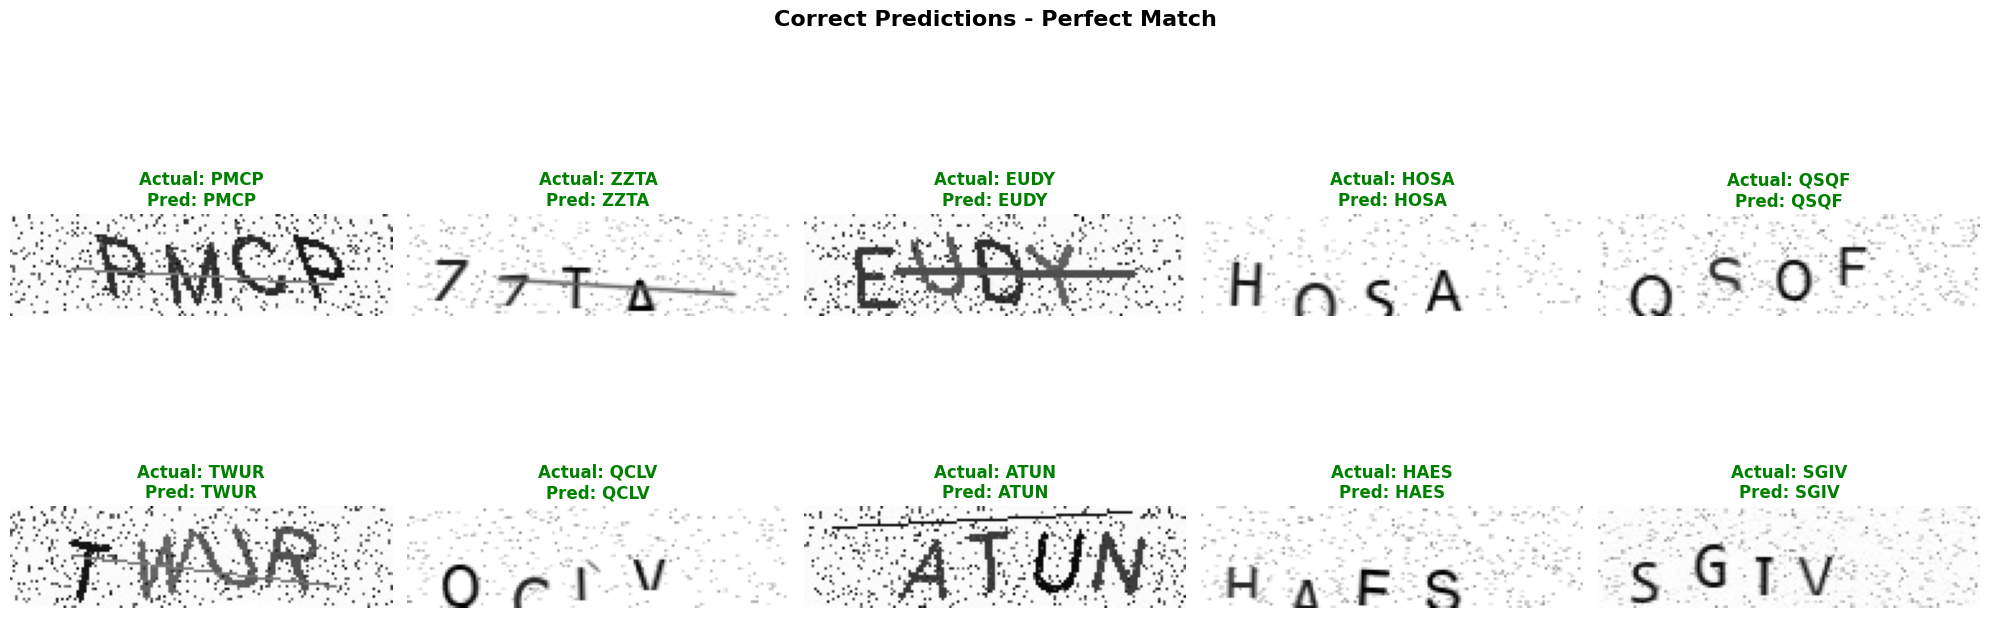


🔴 WRONG Predictions:


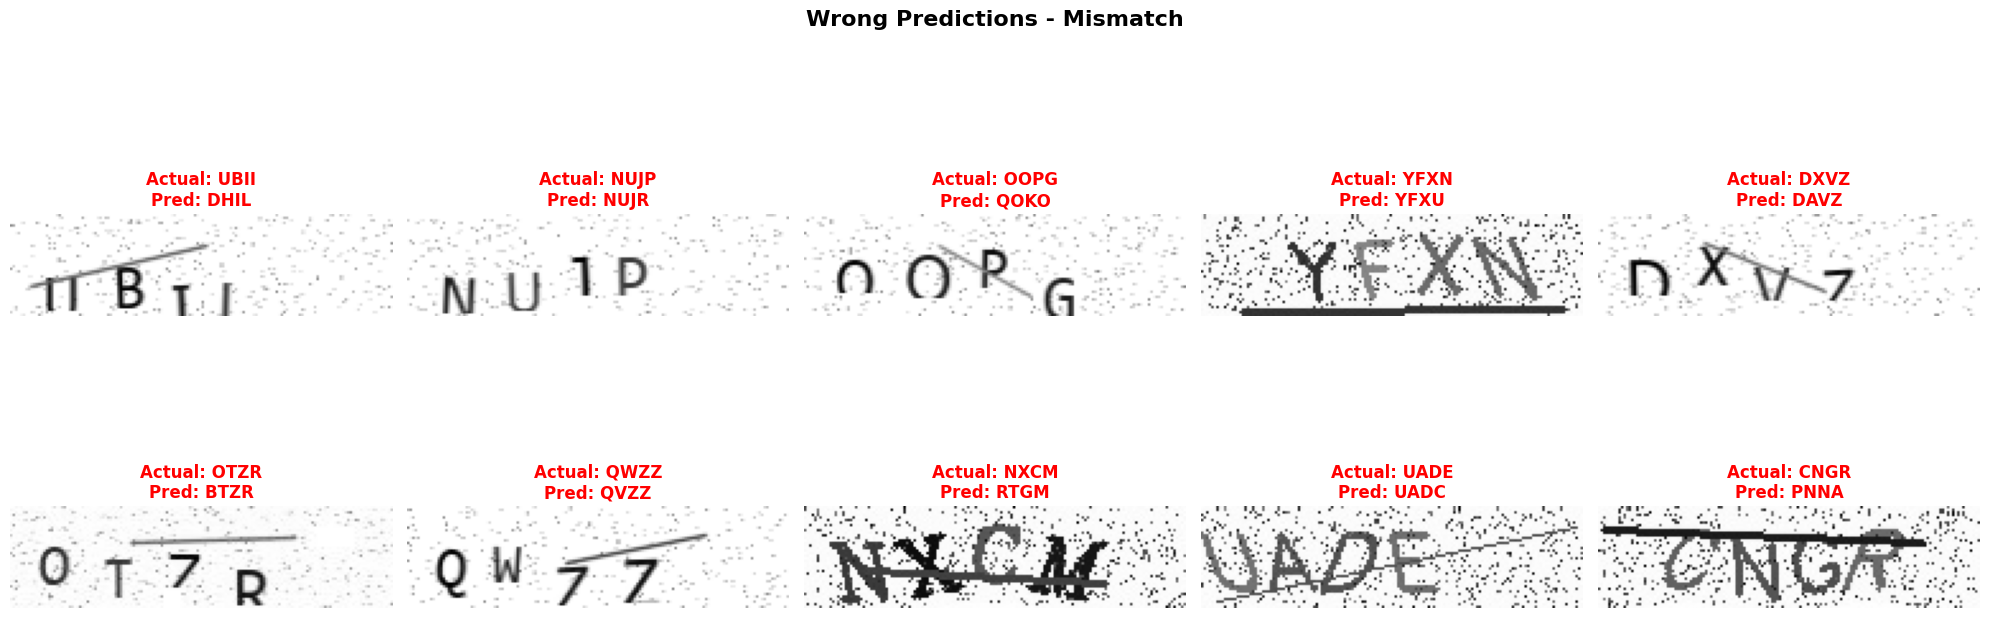


🔍 Detailed Error Analysis:


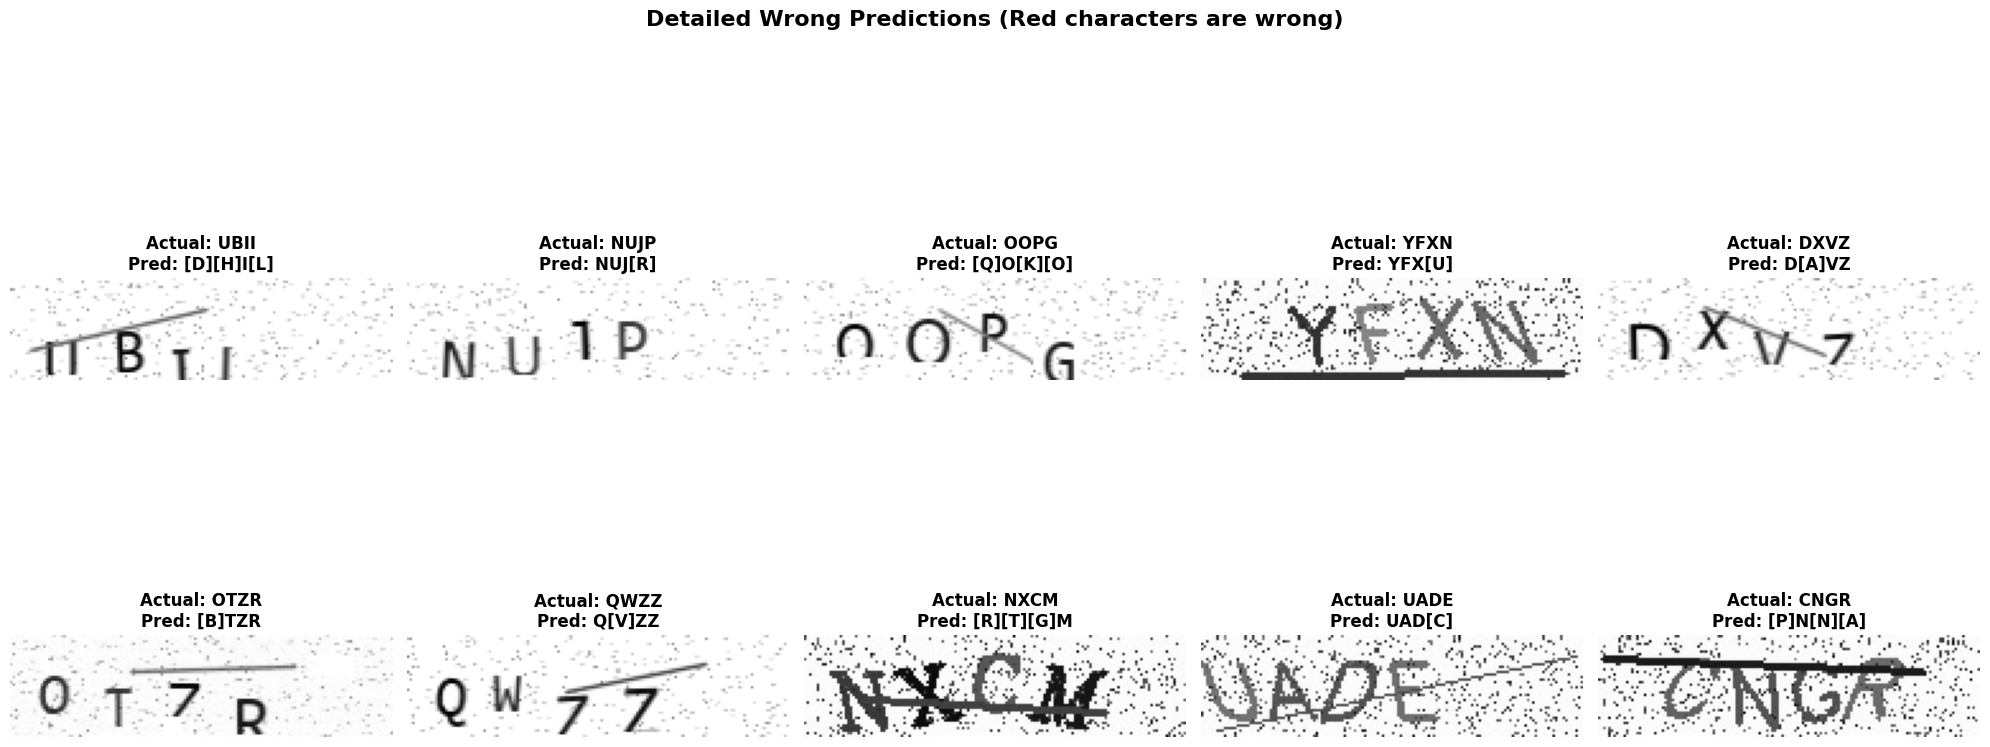

In [ ]:
# Get predictions
print("📸 Collecting predictions...")
(correct_images, correct_actuals, correct_preds,
 wrong_images, wrong_actuals, wrong_preds) = visualize_predictions_fixed(model, val_loader, device)

print(f"✅ Found {len(correct_images)} correct predictions")
print(f"❌ Found {len(wrong_images)} wrong predictions")

# Plot correct predictions
if len(correct_images) > 0:
    print("\n🟢 CORRECT Predictions:")
    plot_captcha_grid(correct_images, correct_actuals, correct_preds,
                     "Correct Predictions - Perfect Match", num_samples=10)
else:
    print("No correct predictions found!")

# Plot wrong predictions
if len(wrong_images) > 0:
    print("\n🔴 WRONG Predictions:")
    plot_captcha_grid(wrong_images, wrong_actuals, wrong_preds,
                     "Wrong Predictions - Mismatch", num_samples=10)

    print("\n🔍 Detailed Error Analysis:")
    plot_detailed_errors(wrong_images, wrong_actuals, wrong_preds, num_samples=10)
else:
    print("🎉 No wrong predictions found! Perfect accuracy!")

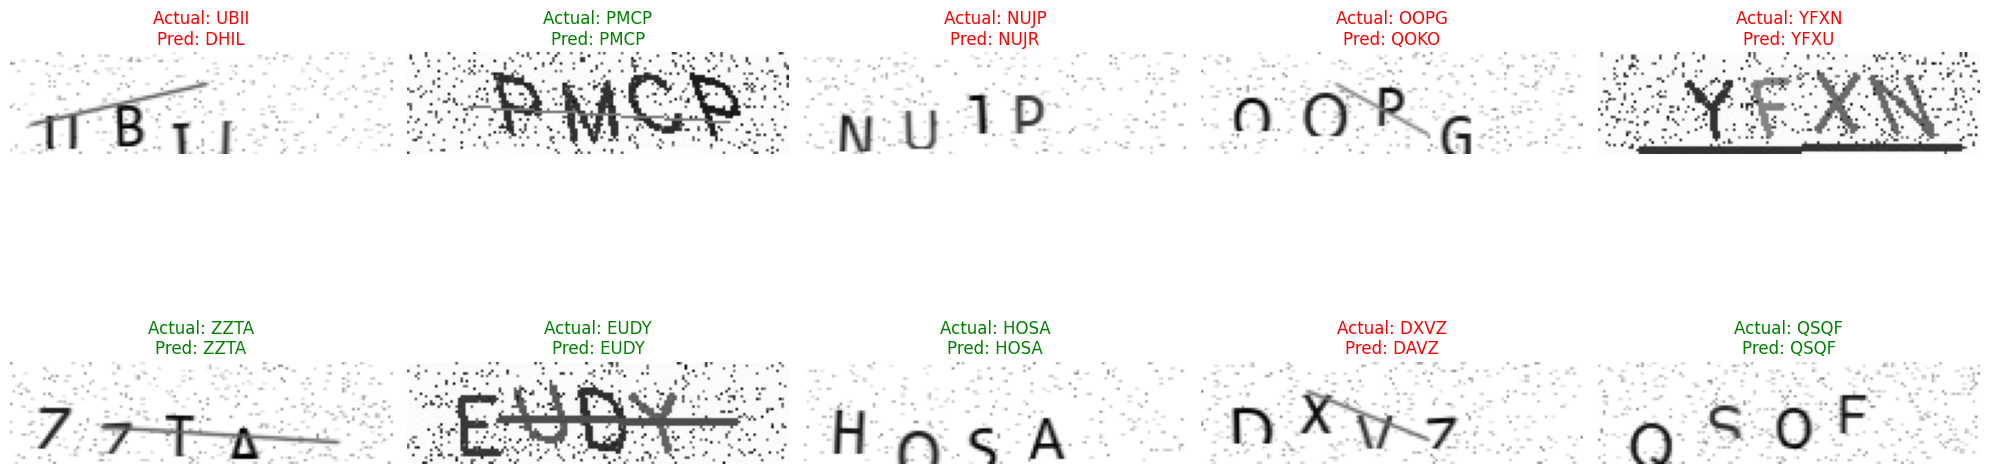

In [ ]:
# Quick and simple visualization
def quick_visualize(model, data_loader, device, num_samples=10):
    model.eval()
    characters = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))

    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            preds = model(X)
            preds_class = torch.argmax(preds, dim=2)

            for i in range(min(num_samples, len(X))):
                img = X[i].cpu().squeeze().numpy()
                actual = ''.join([characters[idx] for idx in y[i].cpu().numpy()])
                pred = ''.join([characters[idx] for idx in preds_class[i].cpu().numpy()])

                ax = axes[i//5, i%5]
                ax.imshow(img, cmap='gray')
                ax.set_title(f"Actual: {actual}\nPred: {pred}",
                           color='green' if actual == pred else 'red')
                ax.axis('off')

            break

    plt.tight_layout()
    plt.show()

# Run quick visualization
quick_visualize(model, val_loader, device)

              precision    recall  f1-score   support

           A       0.67      0.76      0.71     13202
           B       0.55      0.53      0.54     13169
           C       0.63      0.62      0.62     13029
           D       0.59      0.54      0.56     13067
           E       0.58      0.54      0.56     12818
           F       0.54      0.49      0.51     11483
           G       0.62      0.55      0.58     10761
           H       0.68      0.64      0.66     10609
           I       0.79      0.72      0.75      8926
           J       0.80      0.90      0.85      8912
           K       0.77      0.74      0.76     10381
           L       0.88      0.92      0.90      9016
           M       0.76      0.75      0.76     10330
           N       0.61      0.70      0.65     12772
           O       0.69      0.61      0.65      9104
           P       0.63      0.67      0.65     12985
           Q       0.69      0.82      0.75      8989
           R       0.63    

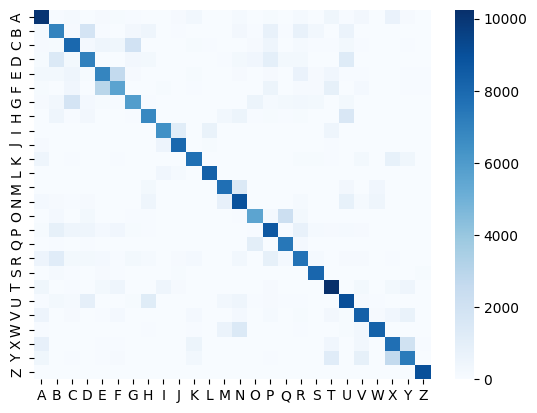

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds, all_targets = [], []

for X, y in val_loader:
    X, y = X.to(device), y.to(device)
    preds = model(X)
    preds_class = torch.argmax(preds, dim=2)  # (batch, 4)

    all_preds.extend(preds_class.cpu().numpy().reshape(-1))
    all_targets.extend(y.cpu().numpy().reshape(-1))

# Generate report
print(classification_report(all_targets, all_preds, target_names=list(string.ascii_uppercase)))

# Confusion matrix
cm = confusion_matrix(all_targets, all_preds)
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=list(string.ascii_uppercase), yticklabels=list(string.ascii_uppercase))
plt.show()


In [ ]:
import time
start = time.time()
# training loop
print("Epoch time:", time.time() - start, "seconds")


Epoch time: 0.00010824203491210938 seconds


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_parameters(model):,}")


Trainable parameters: 621,832


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape, param.numel())


affn.alpha torch.Size([2]) 2
crnn.conv1.0.weight torch.Size([2, 1, 3, 3]) 18
crnn.conv1.0.bias torch.Size([2]) 2
crnn.conv1.1.weight torch.Size([2]) 2
crnn.conv1.1.bias torch.Size([2]) 2
crnn.conv2.0.weight torch.Size([4, 2, 3, 3]) 72
crnn.conv2.0.bias torch.Size([4]) 4
crnn.conv2.1.weight torch.Size([4]) 4
crnn.conv2.1.bias torch.Size([4]) 4
crnn.latent_fc.weight torch.Size([128, 1716]) 219648
crnn.latent_fc.bias torch.Size([128]) 128
crnn.lstm.weight_ih_l0 torch.Size([1024, 128]) 131072
crnn.lstm.weight_hh_l0 torch.Size([1024, 256]) 262144
crnn.lstm.bias_ih_l0 torch.Size([1024]) 1024
crnn.lstm.bias_hh_l0 torch.Size([1024]) 1024
crnn.output_fc.weight torch.Size([26, 256]) 6656
crnn.output_fc.bias torch.Size([26]) 26


In [ ]:


dummy = torch.randn(2, 1, 40, 150).to(device)
summary(model, input_data=dummy)



RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [AFFN: 1, Sequential: 2, Conv2d: 3, BatchNorm2d: 3, ReLU: 3, MaxPool2d: 3, Sequential: 2, Conv2d: 3, BatchNorm2d: 3, ReLU: 3, MaxPool2d: 3, Flatten: 2, Dropout: 2, Linear: 2]

In [ ]:
import os
size_mb = os.path.getsize("final.pth") / 1024**2
print(f"Model size: {size_mb:.2f} MB")


Model size: 2.38 MB


In [ ]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"{name} grad mean: {param.grad.abs().mean().item():.6f}")


affn.alpha grad mean: 0.056603
crnn.conv1.0.weight grad mean: 0.081915
crnn.conv1.0.bias grad mean: 0.000000
crnn.conv1.1.weight grad mean: 0.040436
crnn.conv1.1.bias grad mean: 0.013973
crnn.conv2.0.weight grad mean: 0.069640
crnn.conv2.0.bias grad mean: 0.000000
crnn.conv2.1.weight grad mean: 1.047430
crnn.conv2.1.bias grad mean: 0.749099
crnn.latent_fc.weight grad mean: 0.000646
crnn.latent_fc.bias grad mean: 0.024903
crnn.lstm.weight_ih_l0 grad mean: 0.001090
crnn.lstm.weight_hh_l0 grad mean: 0.000363
crnn.lstm.bias_ih_l0 grad mean: 0.002063
crnn.lstm.bias_hh_l0 grad mean: 0.002063
crnn.output_fc.weight grad mean: 0.003260
crnn.output_fc.bias grad mean: 0.009567


In [ ]:
import torch

def get_gpu_memory():
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**2  # MB
        reserved  = torch.cuda.memory_reserved() / 1024**2   # MB
        total     = torch.cuda.get_device_properties(0).total_memory / 1024**2
        print(f"GPU Memory Allocated: {allocated:.2f} MB")
        print(f"GPU Memory Reserved : {reserved:.2f} MB")
        print(f"GPU Memory Total    : {total:.2f} MB")
    else:
        print("No GPU available.")


In [ ]:
import psutil, os

def get_cpu_memory():
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / 1024**2  # MB
    print(f"CPU RAM Usage: {mem:.2f} MB")


In [ ]:
import time

def measure_latency(model, device, input_size=(1, 1, 40, 150), runs=100):
    model.eval()
    dummy = torch.randn(input_size).to(device)

    # warmup (ignore first run to stabilize GPU)
    _ = model(dummy)

    torch.cuda.synchronize() if device.type == "cuda" else None
    start = time.time()

    for _ in range(runs):
        _ = model(dummy)
    torch.cuda.synchronize() if device.type == "cuda" else None

    end = time.time()
    avg_latency = (end - start) / runs * 1000  # ms
    print(f"Avg Inference Latency: {avg_latency:.2f} ms")
    return avg_latency


In [ ]:
def system_report(model, device, input_size=(1, 1, 40, 150), runs=50):
    print("\n🔎 System Report")
    get_cpu_memory()
    get_gpu_memory()
    latency = measure_latency(model, device, input_size, runs)
    return latency


In [ ]:
latency = system_report(model, device)



🔎 System Report
CPU RAM Usage: 1399.36 MB
GPU Memory Allocated: 225.20 MB
GPU Memory Reserved : 7170.00 MB
GPU Memory Total    : 15095.06 MB


AttributeError: 'tuple' object has no attribute 'size'

In [ ]:
def model_report(model, path="final.pth"):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / 1024**2
        print(f"Model size: {size_mb:.2f} MB")


In [ ]:
# Suppose your model is CRNN or CRNN_AFFN
model_report(model, "final.pth")


Total parameters: 621,832
Trainable parameters: 621,832
Model size: 2.38 MB
